In [1]:
%load_ext autoreload
%autoreload 2

In [78]:
from sklearn import preprocessing
from statsmodels.tsa.stattools import acf, pacf

import pandas as pd
%aimport -pandas

import numpy as np
%aimport -pandas

import matplotlib.pyplot as plt
%aimport -matplotlib.pyplot


%matplotlib inline

import matplotlib.pylab
matplotlib.pylab.rcParams['figure.figsize'] = 15, 6
%aimport -matplotlib.pylab

In [252]:
from data_module import (get_stock_price, get_closing_price, make_time_windows, 
                         make_normalized_train_data, split, denormalize_data, reshape)
from model import (make_model, naive_prediction)
from arima_model import (arima_forecast)

# Machine Learning Engineer Nanodegree
## Capstone Project
Joe Udacity  
December 31st, 2050

## I. Definition
_(approx. 1-2 pages)_

### Project Overview
In this section, look to provide a high-level overview of the project in layman’s terms. Questions to ask yourself when writing this section:
- _Has an overview of the project been provided, such as the problem domain, project origin, and related datasets or input data?_
- _Has enough background information been given so that an uninformed reader would understand the problem domain and following problem statement?_

### Problem Statement
In this section, you will want to clearly define the problem that you are trying to solve, including the strategy (outline of tasks) you will use to achieve the desired solution. You should also thoroughly discuss what the intended solution will be for this problem. Questions to ask yourself when writing this section:
- _Is the problem statement clearly defined? Will the reader understand what you are expecting to solve?_
- _Have you thoroughly discussed how you will attempt to solve the problem?_
- _Is an anticipated solution clearly defined? Will the reader understand what results you are looking for?_

### Metrics
In this section, you will need to clearly define the metrics or calculations you will use to measure performance of a model or result in your project. These calculations and metrics should be justified based on the characteristics of the problem and problem domain. Questions to ask yourself when writing this section:
- _Are the metrics you’ve chosen to measure the performance of your models clearly discussed and defined?_
- _Have you provided reasonable justification for the metrics chosen based on the problem and solution?_


## II. Analysis
_(approx. 2-4 pages)_

### Data Exploration
In this section, you will be expected to analyze the data you are using for the problem. This data can either be in the form of a dataset (or datasets), input data (or input files), or even an environment. The type of data should be thoroughly described and, if possible, have basic statistics and information presented (such as discussion of input features or defining characteristics about the input or environment). Any abnormalities or interesting qualities about the data that may need to be addressed have been identified (such as features that need to be transformed or the possibility of outliers). Questions to ask yourself when writing this section:
- _If a dataset is present for this problem, have you thoroughly discussed certain features about the dataset? Has a data sample been provided to the reader?_
- _If a dataset is present for this problem, are statistics about the dataset calculated and reported? Have any relevant results from this calculation been discussed?_
- _If a dataset is **not** present for this problem, has discussion been made about the input space or input data for your problem?_
- _Are there any abnormalities or characteristics about the input space or dataset that need to be addressed? (categorical variables, missing values, outliers, etc.)_

In [4]:
raw = pd.read_csv('data/prices.csv')
raw.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [276]:
symbols = {x for x in raw['symbol']}
print(len(symbols))
print(list(symbols)[:10])

501
['TSCO', 'ADM', 'LKQ', 'JEC', 'AON', 'FOX', 'MDT', 'ENDP', 'KIM', 'WY']


In [6]:
google_raw = get_stock_price('GOOGL')
google_raw.head()

,open,close,low,high,volume
date,,,,,
2010-01-04,313.788792,313.688694,312.432438,315.070073,3908400.0
2010-01-05,313.903904,312.307316,311.081089,314.234226,6003300.0
2010-01-06,313.243260,304.434452,303.483494,313.243260,7949400.0
2010-01-07,305.005009,297.347355,296.621617,305.305302,12815700.0
2010-01-08,296.296299,301.311314,294.849857,301.926945,9439100.0


date
2010-01-04    313.688694
2010-01-05    312.307316
2010-01-06    304.434452
2010-01-07    297.347355
2010-01-08    301.311314
Name: close, dtype: float64
1762


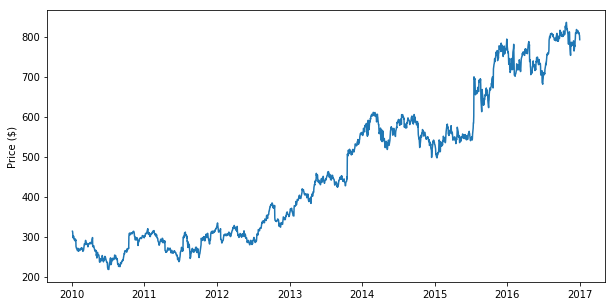

In [281]:
price_close = get_closing_price('GOOGL', as_array=False)
plt.figure(figsize=(10, 5))
plt.plot(price_close)
plt.ylabel('Price ($)')
plt.savefig('google-price-close.png')
print(price_close.head())
print(len(price_close))

In [109]:
# we drop the time index and just use the data as sequence
price_array = get_closing_price('GOOGL', as_array=True)

743


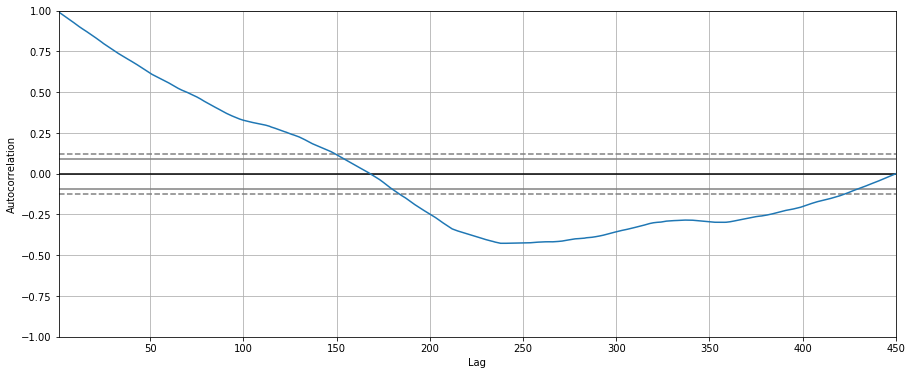

In [287]:
from pandas.plotting import autocorrelation_plot
# TODO how is the autocorrelation relate to the data?
i = np.random.randint(0, 1400)
print(i)
autocorrelation_plot(price_array[i:i+450])
# plt.savefig('autocorrelation-for-2year.png')

- For 2 months data, positive correlation around 4-5 days.
- For 6 months data, positive correlation around 15 days. For rare occasion, like 2012-2014, we have positive correlation on 2-3 months period.
- For 2 years data, correlate around 100 days (3 months).
- For whole data, correlate around 300 days( a year).

## Prepare data


### Make train and test data

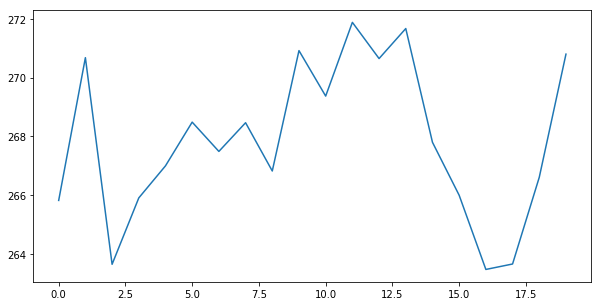

In [296]:
# train_data, test_data = split(price_array, ratio=0.9)
# explore what should be the appropriate length for a window
plt.figure(figsize=(10, 5))
plt.plot(price_array[20:40])
# we observe that during 10 days lot of price jump occur, the good length for a window can be between 5-10 days

## Normalize data

The data we had follows the increasing trend, so the result of the test data will be some number that our train data will never see before. It is better to make the prediction in relative to the observed data.

In [145]:
X, Y, normalizers = make_normalized_train_data(price_array, timesteps=4)
ratio = 0.9
trainX, testX = split(X, ratio)
trainY, testY = split(Y, ratio)
assert len(trainX) == len(trainY) and len(testX) == len(testY)

## Build Model

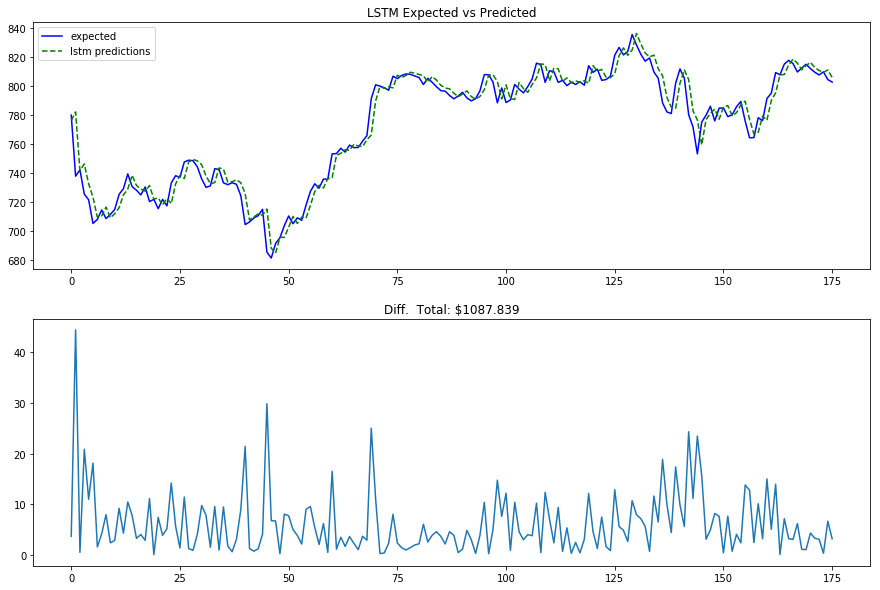

In [273]:
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense

# train_reshaped = reshape(trainX)
# check_reshaped = reshape(trainY)
# input_shape = train_reshaped.shape[1:]

# model = Sequential()
# model.add(LSTM(
#     units=30,
#     input_shape=input_shape,
# #     dropout=0.2,
#     batch_size=1,
#     stateful=True
# ))
# model.add(Dense(input_shape[-1]))
# model.compile(loss='mean_squared_error', optimizer='RMSprop')
# model.fit(train_reshaped, check_reshaped, epochs=20, batch_size=1, verbose=2, shuffle=False)

# _testX = reshape(testX)
# _testY = reshape(testY)
# predict = model.predict(_testX, batch_size=1)

def evaluate_model(testing_data, predictions, normalizers, ratio):
    _, _norm = split(normalizers, ratio)
    denorm_expected = denormalize_data(testing_data, _norm)
    preds = denormalize_data(predictions, _norm)

    plt.figure(figsize=(15, 10))
    plt.subplot(2, 1, 1)
    plt.plot(denorm_expected, color='blue', label='expected')
    plt.plot(preds[:], color='green', linestyle='--', label='lstm predictions')
    plt.legend(loc='best')
    plt.title('LSTM Expected vs Predicted')
    plt.subplot(2, 1, 2)
    diff = np.absolute(denorm_expected - preds.flatten())
    plt.plot(diff)
    plt.title('Diff.  Total: ${:.3f}'.format(diff.sum()))
    plt.savefig('lstm-predictions-compare.png')

#     print(_testY.flatten()[25:30])
#     print(predict.flatten()[25:30])
    
evaluate_model(testY, predict, normalizers, ratio)

## Metric function

#### Making a naive guess

Create a naive guess for baseline benchmark

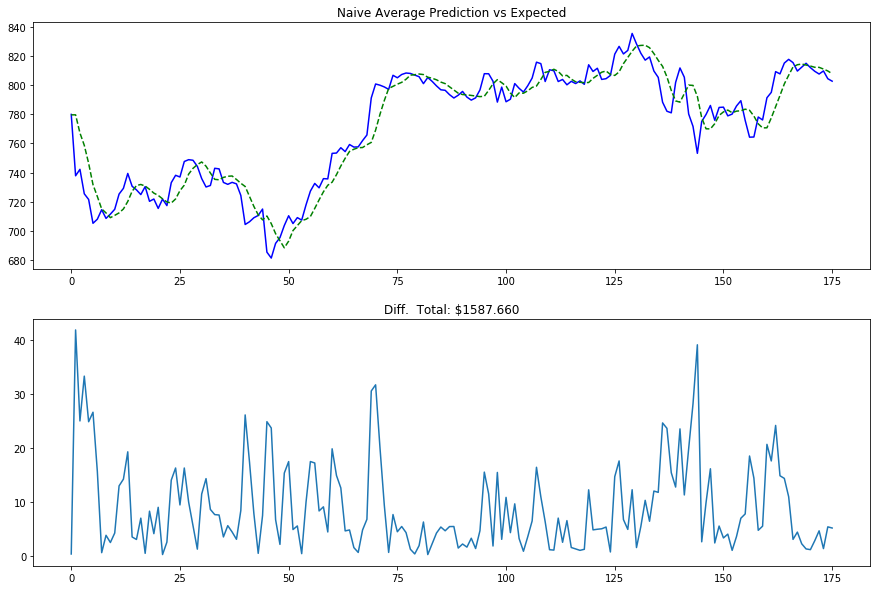

In [272]:
def compare_naive_predictions(data, timesteps, test_ratio):
    train, test = make_time_windows(data, timesteps)
    predictions = naive_prediction(train)  
    _, testY = split(test, ratio)
    _, preds = split(predictions, ratio)

    plt.figure(figsize=(15, 10))
    plt.subplot(2, 1, 1)
    plt.plot(testY, color='blue', label='expected')
    plt.plot(preds, color='green', linestyle='--', label='naive predictions')
    plt.title('Naive Average Prediction vs Expected')
    plt.subplot(2, 1, 2)
    diff = np.absolute(testY - preds)
    plt.plot(diff)
    plt.title('Diff.  Total: ${:.3f}'.format(diff.sum()))
    plt.savefig('naive-guess-compare.png')

compare_naive_predictions(price_array, timesteps=4, test_ratio=0.9)

# plt.savefig('naive-guess-{}.png'.format(SEQUENCE_LENGTH))

Note: There seem to be some missing data (2010-01-09, 2010-01-10, 2010-01-16, 2010-01-17, 2010-01-18) 

In [141]:
def is_equal(arr_a, arr_b):
    return np.all(np.equal(arr_a, arr_b))

# w = train[0]
# w = np.reshape(train[0], (-1, 1))
# # w = np.reshape(train[0], (1, -1))
# scaler = preprocessing.MinMaxScaler()
# scaler.fit(w)
# scaler.data_min_
# m = scaler.transform(w)
# # scaler.transform([314])
# # scaler.inverse_transform([1.0071699])
# t = preprocessing.minmax_scale(train[0])
# scaler.inverse_transform(m)

In [143]:
# %%time
def normalize_windows(windows):
#     res = [preprocessing.minmax_scale(w) for w in windows]
    for i, w in enumerate(windows):
        scaler = preprocessing.MinMaxScaler()
        scaler.fit(np.reshape(w, (1, -1)))
        t = scaler.transform(np.reshape(w, (1, -1)))
        print(np.reshape(w, (1, -1)))
        print(t)
#         print(res[i])
#         assert is_equal(t, res[i])
#     return res

def denormalize_windows(original_windows, norm_windows):
    res = []
    for i in range(len(original_windows)):
        a, b = original_windows[i], norm_windows[i]
        scaler = preprocessing.MinMaxScaler()
        scaler.fit(np.reshape(a, (1, -1)))
        res.append(scaler.inverse_transform(b.reshape(1, -1)))
    return res

# t = normalize_windows(train)
# print(t[0])
# print(train[0])
# f = denormalize_windows(train, t)
# print(f[0])

## Explore ARIMA

A look at the plot of price clearly shows that the data has an upward trend, and not stationary. A step to make the data stationary is needed.

In [220]:
arima_predictions, arima_expect = arima_forecast()

/home/vu/anaconda3/envs/tensorflow17/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/home/vu/anaconda3/envs/tensorflow17/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/home/vu/anaconda3/envs/tensorflow17/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


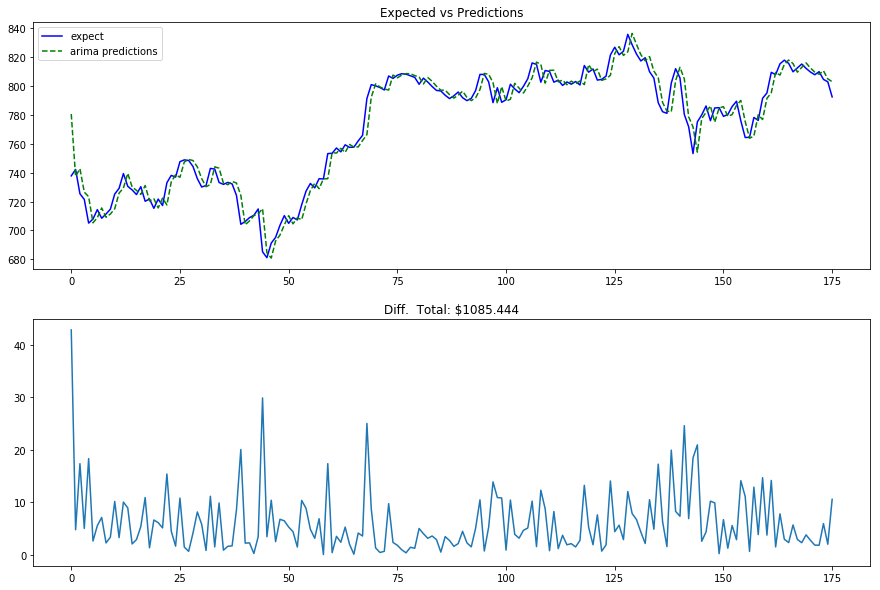

In [275]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(arima_expect, color='blue', label='expect')
plt.plot(arima_predictions[:], color='green', linestyle='--', label='arima predictions')
plt.title('Expected vs Predictions')
plt.legend(loc='best')
plt.subplot(2, 1, 2)
diff = np.absolute(np.array(arima_expect).flatten() - np.array(arima_predictions).flatten())
plt.plot(diff)
plt.title('Diff.  Total: ${:.3f}'.format(diff.sum()))
plt.savefig('arima-predict-compare.png')

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.plot(train_range)

In [ ]:
# the data likely does not have any trend nor seasonality, we explore just for fun

train_data_log = np.log(train_range)
decomposition = seasonal_decompose(train_data_log.asfreq('C', method='ffill'))

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# plt.subplot(411)
# plt.plot(train_data_log, label='Original')
# plt.legend(loc='best')
# plt.subplot(412)
# plt.plot(trend, label='Trend')
# plt.legend(loc='best')
# plt.subplot(413)
# plt.plot(seasonal,label='Seasonality')
# plt.legend(loc='best')
# plt.subplot(414)
plt.plot(residual, label='Residuals')
# plt.legend(loc='best')

In [ ]:
log_diff = train_data_log - train_data_log.shift()
plt.plot(log_diff)

In [ ]:
lag_acf = acf(log_diff, nlags=20)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

In [ ]:
# lag_pacf = pacf(log_diff, nlags=20, method='ols')


### Exploratory Visualization
In this section, you will need to provide some form of visualization that summarizes or extracts a relevant characteristic or feature about the data. The visualization should adequately support the data being used. Discuss why this visualization was chosen and how it is relevant. Questions to ask yourself when writing this section:
- _Have you visualized a relevant characteristic or feature about the dataset or input data?_
- _Is the visualization thoroughly analyzed and discussed?_
- _If a plot is provided, are the axes, title, and datum clearly defined?_

### Algorithms and Techniques
In this section, you will need to discuss the algorithms and techniques you intend to use for solving the problem. You should justify the use of each one based on the characteristics of the problem and the problem domain. Questions to ask yourself when writing this section:
- _Are the algorithms you will use, including any default variables/parameters in the project clearly defined?_
- _Are the techniques to be used thoroughly discussed and justified?_
- _Is it made clear how the input data or datasets will be handled by the algorithms and techniques chosen?_

### Benchmark
In this section, you will need to provide a clearly defined benchmark result or threshold for comparing across performances obtained by your solution. The reasoning behind the benchmark (in the case where it is not an established result) should be discussed. Questions to ask yourself when writing this section:
- _Has some result or value been provided that acts as a benchmark for measuring performance?_
- _Is it clear how this result or value was obtained (whether by data or by hypothesis)?_

## III. Methodology
_(approx. 3-5 pages)_

### Data Preprocessing
In this section, all of your preprocessing steps will need to be clearly documented, if any were necessary. From the previous section, any of the abnormalities or characteristics that you identified about the dataset will be addressed and corrected here. Questions to ask yourself when writing this section:
- _If the algorithms chosen require preprocessing steps like feature selection or feature transformations, have they been properly documented?_
- _Based on the **Data Exploration** section, if there were abnormalities or characteristics that needed to be addressed, have they been properly corrected?_
- _If no preprocessing is needed, has it been made clear why?_

### Implementation
In this section, the process for which metrics, algorithms, and techniques that you implemented for the given data will need to be clearly documented. It should be abundantly clear how the implementation was carried out, and discussion should be made regarding any complications that occurred during this process. Questions to ask yourself when writing this section:
- _Is it made clear how the algorithms and techniques were implemented with the given datasets or input data?_
- _Were there any complications with the original metrics or techniques that required changing prior to acquiring a solution?_
- _Was there any part of the coding process (e.g., writing complicated functions) that should be documented?_

### Refinement
In this section, you will need to discuss the process of improvement you made upon the algorithms and techniques you used in your implementation. For example, adjusting parameters for certain models to acquire improved solutions would fall under the refinement category. Your initial and final solutions should be reported, as well as any significant intermediate results as necessary. Questions to ask yourself when writing this section:
- _Has an initial solution been found and clearly reported?_
- _Is the process of improvement clearly documented, such as what techniques were used?_
- _Are intermediate and final solutions clearly reported as the process is improved?_


## IV. Results
_(approx. 2-3 pages)_

### Model Evaluation and Validation
In this section, the final model and any supporting qualities should be evaluated in detail. It should be clear how the final model was derived and why this model was chosen. In addition, some type of analysis should be used to validate the robustness of this model and its solution, such as manipulating the input data or environment to see how the model’s solution is affected (this is called sensitivity analysis). Questions to ask yourself when writing this section:
- _Is the final model reasonable and aligning with solution expectations? Are the final parameters of the model appropriate?_
- _Has the final model been tested with various inputs to evaluate whether the model generalizes well to unseen data?_
- _Is the model robust enough for the problem? Do small perturbations (changes) in training data or the input space greatly affect the results?_
- _Can results found from the model be trusted?_

### Justification
In this section, your model’s final solution and its results should be compared to the benchmark you established earlier in the project using some type of statistical analysis. You should also justify whether these results and the solution are significant enough to have solved the problem posed in the project. Questions to ask yourself when writing this section:
- _Are the final results found stronger than the benchmark result reported earlier?_
- _Have you thoroughly analyzed and discussed the final solution?_
- _Is the final solution significant enough to have solved the problem?_


## V. Conclusion
_(approx. 1-2 pages)_

### Free-Form Visualization
In this section, you will need to provide some form of visualization that emphasizes an important quality about the project. It is much more free-form, but should reasonably support a significant result or characteristic about the problem that you want to discuss. Questions to ask yourself when writing this section:
- _Have you visualized a relevant or important quality about the problem, dataset, input data, or results?_
- _Is the visualization thoroughly analyzed and discussed?_
- _If a plot is provided, are the axes, title, and datum clearly defined?_

### Reflection
In this section, you will summarize the entire end-to-end problem solution and discuss one or two particular aspects of the project you found interesting or difficult. You are expected to reflect on the project as a whole to show that you have a firm understanding of the entire process employed in your work. Questions to ask yourself when writing this section:
- _Have you thoroughly summarized the entire process you used for this project?_
- _Were there any interesting aspects of the project?_
- _Were there any difficult aspects of the project?_
- _Does the final model and solution fit your expectations for the problem, and should it be used in a general setting to solve these types of problems?_

### Improvement
In this section, you will need to provide discussion as to how one aspect of the implementation you designed could be improved. As an example, consider ways your implementation can be made more general, and what would need to be modified. You do not need to make this improvement, but the potential solutions resulting from these changes are considered and compared/contrasted to your current solution. Questions to ask yourself when writing this section:
- _Are there further improvements that could be made on the algorithms or techniques you used in this project?_
- _Were there algorithms or techniques you researched that you did not know how to implement, but would consider using if you knew how?_
- _If you used your final solution as the new benchmark, do you think an even better solution exists?_

-----------

**Before submitting, ask yourself. . .**

- Does the project report you’ve written follow a well-organized structure similar to that of the project template?
- Is each section (particularly **Analysis** and **Methodology**) written in a clear, concise and specific fashion? Are there any ambiguous terms or phrases that need clarification?
- Would the intended audience of your project be able to understand your analysis, methods, and results?
- Have you properly proof-read your project report to assure there are minimal grammatical and spelling mistakes?
- Are all the resources used for this project correctly cited and referenced?
- Is the code that implements your solution easily readable and properly commented?
- Does the code execute without error and produce results similar to those reported?